# Vegetation Phenology <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


Random online python phenology functions that might help:

- https://gist.github.com/YanCheng-go/d4e17831f294199443d0f7682558e608

- https://github.com/JavierLopatin/PhenoPY


Dale's private repo of updated stats

    # pip list | grep hdstats
    python -m pip install git+https://github.com/daleroberts/hdstats


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook calculates vegetation phenology changes using Sentinel 2 data.
To detect changes in plant life for Landsat, the script uses either the `Normalized Difference Vegetation Index (NDVI)` or the `Enhanced Vegetation Index (EVI)`, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.
This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel 2 data for an area of interest.
2. Calculate the vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health
4. Calculate zonal phenology statistics, such as beginning and end of season for each year using `xr_phenology`
5. Interpolate the vegetation timeseries to increase the temporal resolution, and recalculate phenology statistics
5. Calculate per-pixel phenology statistics

<!-- There are two output products for this notebook:

* The first output product is a time series boxplot of NDVI or EVI with the data potentially binned by week, month, week of year, or month of year. 
* The second output product is a time series lineplot of the mean NDVI or EVI for each year, with the data potentially binned by week or month. This product is useful for comparing years to each other. -->

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import hdstats
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_temporal_statistics import xr_phenology, temporal_statistics
# from deafrica_dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

%load_ext autoreload
%autoreload 2

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `NDVI` or `EVI`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest
lat = 22.817 #-34.288
lon = 28.518 #20.012
lon_buffer = 0.0175
lat_buffer = 0.004

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2018-01', '2018-06')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [ ]:
# display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [4]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red', 'nir'],
    'resolution': (-20,20),
    'output_crs': 'epsg:6933'
}

# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
#               dask_chunks={'x':50, 'y':50,'time':1},
              **query,
              )

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 34 time steps
<xarray.Dataset>
Dimensions:      (time: 34, x: 170, y: 48)
Coordinates:
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2018-01-02T08:53:30 ... 2018-06-26T08:52:59
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
Data variables:
    red          (time, y, x) float32 462.0 3178.0 4616.0 ... 4796.0 4784.0
    nir          (time, y, x) float32 4828.0 4808.0 5488.0 ... 5480.0 5460.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


**Once the load is complete**, we can plot the data as a true-colour image using the `rgb` function.  

In [ ]:
# rgb(ds, index=[0,5,10,15,20,25], col_wrap=2)

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='s2'` since we're working with Sentinel-2 data.

In [5]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = (ds.nir - ds.red)/(ds.nir + ds.red)
# ds = calculate_indices(ds, index=veg_proxy, collection='s2')
# ds

In [8]:
phen = temporal_statistics(ds, stats=['discordance','f_std', 'f_mean', 'f_median',
                                'mean_change','med_change', 'abs_change', 
                                'complexity','central_diff', 'num_peaks'])

Completing...
   Statistics:
      discordance
      f_std
      f_mean
      f_median
      mean_change
      med_change
      abs_change
      complexity
      central_diff
      num_peaks


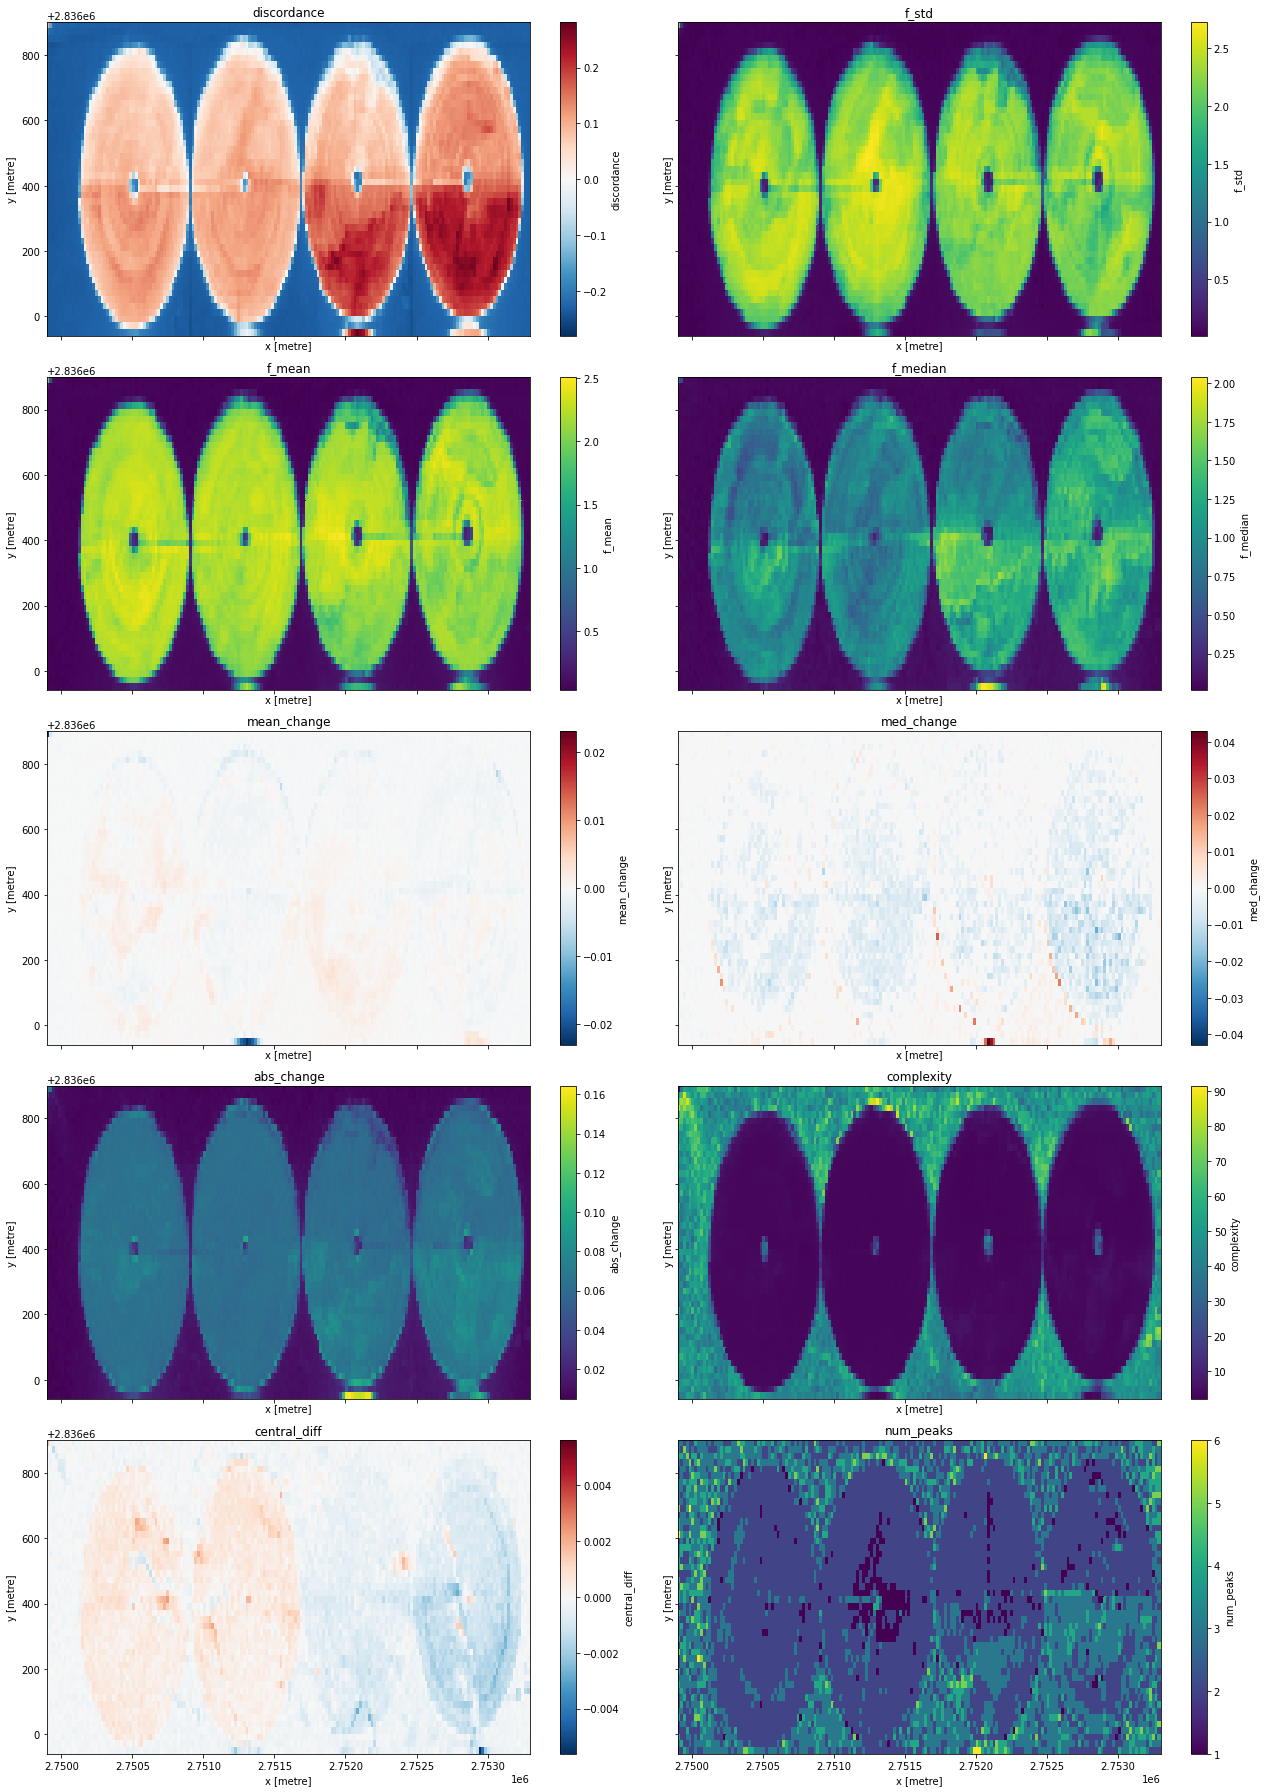

In [9]:
#set up figure
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(18,25), sharex=True, sharey=True)

#start of season
phen.discordance.plot(ax=ax[0,0])
ax[0,0].set_title('discordance')
phen.f_std.plot(ax=ax[0,1])
ax[0,1].set_title('f_std')

#peak of season
phen.f_mean.plot(ax=ax[1,0])
ax[1,0].set_title('f_mean')
phen.f_median.plot(ax=ax[1,1])
ax[1,1].set_title('f_median')

#end of season
phen.mean_change.plot(ax=ax[2,0])
ax[2,0].set_title('mean_change')
phen.med_change.plot(ax=ax[2,1])
ax[2,1].set_title('med_change')

#Length of Season
phen.abs_change.plot(ax=ax[3,0])
ax[3,0].set_title('abs_change');

#Amplitude
phen.complexity.plot(ax=ax[3,1])
ax[3,1].set_title('complexity')

#rate of growth
phen.central_diff.plot(ax=ax[4,0])
ax[4,0].set_title('central_diff')

#rate of Sensescence
phen.num_peaks.plot(ax=ax[4,1])
ax[4,1].set_title('num_peaks');

plt.tight_layout();

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal timeseries over the region of interest. First we will do a simple plot of the zonal mean of the data.  


In [ ]:
np.unique(ds.NDVI.isnull().all('time'))

In [ ]:
ds.NDVI.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('zonal mean of vegetation timeseries');

Due to the infrequency of satellite passes, the presence of cloud, or because we desire evenly spaced data-points, we may want to interpolate data points between the satellite observations. Xarray has inbuilt methods `.resample()` and `.interpolate()` to do just this. We can also fill any `NaNs` (Not a Number) in the dataset where data is missing, to do this we will first use xarray's `.interpolate_na()` method before we resample the time-series.


#### Interpolate vegetation time-series
Below we will use a simple `linear` interpolation method to resample our vegetation time-series so it has a data-point once every week (i.e. `.resample(time='1W')`).

In [ ]:
#fill missing values in the NDVI timeseries interpolated values
ndvi = ds.NDVI.interpolate_na(dim='time', method='linear')
#interpolate the data
ndvi_interpolated = ndvi.mean(['x', 'y']).resample(time='1W').interpolate('linear')
#plot the interpolated data
ndvi_interpolated.plot.line('b-^', figsize=(11,4))
plt.title('Interpolated vegetation timeseries');

#### Rolling mean on vegetation time-series

Instead of interpolating values, we may wish to smooth-out a time series by calculting a `rolling mean` over a specified window-size. Below we will demostrate this by calculating a rolling mean across every four time steps. The larger the window-size, the smoother the curve will be, but at the cost of more granular detail in the curve.

In [ ]:
#interpolate the data
ndvi_rolling = ndvi.mean(['x', 'y']).rolling(time=4, min_periods=1).mean()
#plot the interpolated data
ndvi_rolling.plot.line('b-^', figsize=(11,4))
plt.title('Rolling mean vegetation time-series');

## Calculate phenology statistics using `xr_phenology`

The DE Africa function `xr_phenology` can caluclate a number of summary phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis (DOY = day-of-year):

            SOS = DOY of start of season
            POS = DOY of peak of season
            EOS = DOY of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (DOY)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

By default the function will return all of the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

The `xr_phenology` function also allows for interpolating the time-series, ca;culating rolling means, and/or filling `NaNs` in the same way as we did above, the interpolations will occur before the statistics are calculated.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal time-series to the function and plot the results on the same curves as above.

In [ ]:
%%time
#calculate phenology on the zonal mean of the dataset
zonal_phen = xr_phenology(ds.NDVI.mean(['x', 'y']),
                       stats=['SOS', 'POS', 'EOS',
                             'vSOS', 'vPOS', 'vEOS'
                             ],
                       method_sos='median',
                       method_eos='median',
                       interpolate_na = True,   
#                        interpolate = True,
                       rolling_mean = 4,
                       interp_method = 'linear'
                   )

zonal_phen

Plot the results with our statistcs annotated on the plot

In [ ]:
# Use DOY results to create a datetime object 
year = str(zonal_phen.time.dt.year.values) + " "
eos_dt = dt.datetime.strptime(year+str(zonal_phen.EOS.values), '%Y %j')
sos_dt = dt.datetime.strptime(year+str(zonal_phen.SOS.values), '%Y %j')
pos_dt = dt.datetime.strptime(year+str(zonal_phen.POS.values), '%Y %j')

#create plot
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(ndvi_rolling.time,
         ndvi_rolling,
        'b-^')

#add start of season
ax.plot(sos_dt, zonal_phen.vSOS, 'or')
ax.annotate('SOS', xy=(sos_dt, zonal_phen.vSOS.values), xytext=(-15, 20),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

#add end of season
ax.plot(eos_dt, zonal_phen.vEOS, 'or')
ax.annotate('EOS', xy=(eos_dt, zonal_phen.vEOS.values), xytext=(0, 20),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

#add peak of season
ax.plot(pos_dt, zonal_phen.vPOS, 'or')
ax.annotate('POS', xy=(pos_dt, zonal_phen.vPOS.values), xytext=(-10, -25),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

plt.ylabel('NDVI')
plt.title('Phenology statistics');

### Per-pixel phenology statistics

In [ ]:
# ndvi

In [ ]:
%%time
#calculate phenology stats on every pixel in dataset
phen = xr_phenology(ds.NDVI,
                    interpolate_na=True,
                    rolling_mean=4,
#                     interp_method='linear',
               )
phen

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

In [ ]:
#set up figure
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(18,25), sharex=True, sharey=True)

#start of season
phen.SOS.plot(ax=ax[0,0], cmap='magma_r')
ax[0,0].set_title('Start of Season (DOY)')
phen.vSOS.plot(ax=ax[0,1], cmap='YlGn', vmax=0.5)
ax[0,1].set_title('NDVI at SOS')

#peak of season
phen.POS.plot(ax=ax[1,0], cmap='magma_r')
ax[1,0].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[1,1], cmap='YlGn',vmax=0.5)
ax[1,1].set_title('NDVI at POS')

#end of season
phen.EOS.plot(ax=ax[2,0], cmap='magma_r')
ax[2,0].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[2,1], cmap='YlGn', vmax=0.5)
ax[2,1].set_title('NDVI at EOS')

#Length of Season
phen.LOS.plot(ax=ax[3,0], cmap='magma_r')
ax[3,0].set_title('Length of Season (DOY)');

#Amplitude
phen.AOS.plot(ax=ax[3,1], cmap='YlGn', vmax=0.5)
ax[3,1].set_title('Amplitude of Season')

#rate of growth
phen.ROG.plot(ax=ax[4,0],cmap='coolwarm_r', vmin=-0.02, vmax=0.02)
ax[4,0].set_title('Rate of Growth')

#rate of Sensescence
phen.ROS.plot(ax=ax[4,1],cmap='coolwarm_r', vmin=-0.02, vmax=0.02)
ax[4,1].set_title('Rate of Senescence');



***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

In [ ]:
# def poly_fit(time, data, degree):
    
#     pfit = np.polyfit(time, data, degree) 
    
#     return np.transpose(np.polyval(pfit,time))

# def poly_fit_smooth(time, data, degree, n_pts):
#         """
#         """
    
#         time_smooth_inds = np.linspace(0, len(time), n_pts)
#         time_smooth = np.interp(time_smooth_inds, np.arange(len(time)), time)

#         data_smooth = np.array([np.array([coef * (x_val ** current_degree) for
#                                 coef, current_degree in zip(np.polyfit(time, data, degree),
#                                 range(degree, -1, -1))]).sum() for x_val in time_smooth])

#         return data_smooth

# def xr_polyfit(doy,
#                da,
#                degree,
#                interp_multiplier=1):    
    
#     # Fit polynomial curve to observed data points
#     if interp_multiplier==1:
#         print('Fitting polynomial curve to existing observations')
#         pfit = xr.apply_ufunc(
#             poly_fit,
#             doy,
#             da, 
#             kwargs={'degree':degree},
#             input_core_dims=[["time"], ["time"]], 
#             output_core_dims=[['time']],
#             vectorize=True,  
#             dask="parallelized",
#             output_dtypes=[da.dtype],
#         )
    
#     if interp_multiplier > 1:
#         print("Fitting polynomial curve to "+str(len(doy)*interp_multiplier)+
#                                                       " interpolated points")
#         pfit = xr.apply_ufunc(
#             poly_fit_smooth,  # The function
#             doy,# time
#             da,#.chunk({'time': -1}), #the data
#             kwargs={'degree':degree, 'n_pts':len(doy)*interp_multiplier},
#             input_core_dims=[["time"], ["time"]], 
#             output_core_dims=[['new_time']], 
#             output_sizes = ({'new_time':len(doy)*interp_multiplier}),
#             exclude_dims=set(("time",)),
#             vectorize=True, 
#             dask="parallelized",
#             output_dtypes=[da.dtype],
#         ).rename({'new_time':'time'})
    
#         # Map 'dayofyear' onto interpolated time dim
#         time_smooth_inds = np.linspace(0, len(doy), len(doy)*interp_multiplier)
#         new_datetimes = np.interp(time_smooth_inds, np.arange(len(doy)), doy)
#         pfit = pfit.assign_coords({'time':new_datetimes})
    
#     return pfit

# # da=xr_polyfit(dayofyear=dayofyear, 
# #               da=da,
# #               degree=degree,
# #               interp_multiplier=interp_multiplier)